In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Фиксация random_state для воспроизводимости результатов
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
# Загрузка очищенного датасета из ЛР-1
df = pd.read_csv('../data/raw/diabetes_clean.csv')

# Вывод основной информации о данных
print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
df.head()

Размер датасета: (768, 9)

Первые 5 строк:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.670968,0.489796,0.304348,0.133413,0.314928,0.234415,0.483333,1
1,0.058824,0.264516,0.428571,0.239130,0.133413,0.171779,0.116567,0.166667,0
2,0.470588,0.896774,0.408163,0.239130,0.133413,0.104294,0.253629,0.183333,1
3,0.058824,0.290323,0.428571,0.173913,0.118840,0.202454,0.038002,0.000000,0
4,0.000000,0.600000,0.163265,0.304348,0.146484,0.509202,0.479078,0.200000,1


In [4]:
# Проверка информации о данных
print("Информация о датасете:")
print(df.info())
print("\nСтатистика данных:")
df.describe()

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 54.1 KB
None

Статистика данных:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,0.225720,0.501205,0.493638,0.237680,0.133042,0.290299,0.162645,0.203331,0.348958
std,0.196715,0.196361,0.119355,0.080895,0.009512,0.136349,0.121945,0.193807,0.476951
min,0.000000,0.000000,0.163265,0.081522,0.118840,0.000000,0.000000,0.000000,0.000000
25%,0.058824,0.359677,0.408163,0.195652,0.129207,0.190184,0.070773,0.050000,0.000000
50%,0.176471,0.470968,0.491863,0.239130,0.133413,0.290389,0.125747,0.133333,0.000000
75%,0.352941,0.620968,0.571429,0.271739,0.136118,0.376278,0.234095,0.333333,1.000000
max,0.794118,1.000000,0.816327,0.385870,0.146484,0.655419,0.479078,0.758333,1.000000


Распределение целевой переменной (Outcome):
Outcome
0    500
1    268
Name: count, dtype: int64

Доли классов:
Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64


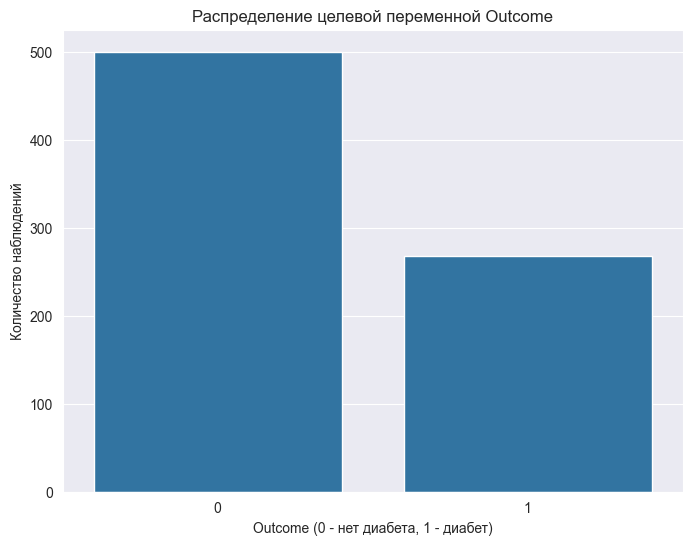

In [5]:
# Проверка баланса целевой переменной
print("Распределение целевой переменной (Outcome):")
print(df['Outcome'].value_counts())
print("\nДоли классов:")
print(df['Outcome'].value_counts(normalize=True))

# Визуализация распределения целевой переменной
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Outcome')
plt.title('Распределение целевой переменной Outcome')
plt.xlabel('Outcome (0 - нет диабета, 1 - диабет)')
plt.ylabel('Количество наблюдений')
plt.show()

In [6]:
# Разделение на признаки и целевую переменную
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Список всех признаков (все числовые)
feature_names = X.columns.tolist()
print("Список признаков:", feature_names)

Список признаков: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [7]:
# Создание ColumnTransformer для обработки числовых признаков
# Все признаки уже нормализованы в [0,1] из ЛР-1, но добавим StandardScaler для стандартизации
# и SimpleImputer для обработки возможных пропусков (хотя в очищенном датасете их нет)

numeric_features = feature_names
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # стратегия - медиана
    ('scaler', StandardScaler())  # стандартизация
])

# Объединение в ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

print("Структура препроцессора создана успешно")

Структура препроцессора создана успешно


In [8]:
# Стратифицированное разбиение на train/valid/test в соотношении 60/20/20
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,  # стратификация по целевой переменной
    random_state=RANDOM_STATE
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, 
    test_size=0.25,  # 0.25 от 80% = 20% от общего объема
    stratify=y_temp,  # стратификация
    random_state=RANDOM_STATE
)

print("Размеры выборок:")
print(f"Обучающая выборка (train): {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Валидационная выборка (valid): {X_valid.shape[0]} samples ({X_valid.shape[0]/len(X)*100:.1f}%)")
print(f"Тестовая выборка (test): {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

Размеры выборок:
Обучающая выборка (train): 460 samples (59.9%)
Валидационная выборка (valid): 154 samples (20.1%)
Тестовая выборка (test): 154 samples (20.1%)


In [9]:
# Проверка распределения целевой переменной в разных выборках
def check_stratification(y_train, y_valid, y_test, y_original):
    """Функция для проверки стратификации"""
    original_dist = y_original.value_counts(normalize=True)
    train_dist = y_train.value_counts(normalize=True)
    valid_dist = y_valid.value_counts(normalize=True)
    test_dist = y_test.value_counts(normalize=True)
    
    stratification_check = pd.DataFrame({
        'Original': original_dist,
        'Train': train_dist,
        'Valid': valid_dist,
        'Test': test_dist
    })
    
    return stratification_check

# Проверка стратификации
strat_check = check_stratification(y_train, y_valid, y_test, y)
print("Проверка стратификации (доли классов):")
print(strat_check)

Проверка стратификации (доли классов):
         Original     Train     Valid      Test
Outcome                                        
0        0.651042  0.652174  0.649351  0.649351
1        0.348958  0.347826  0.350649  0.350649


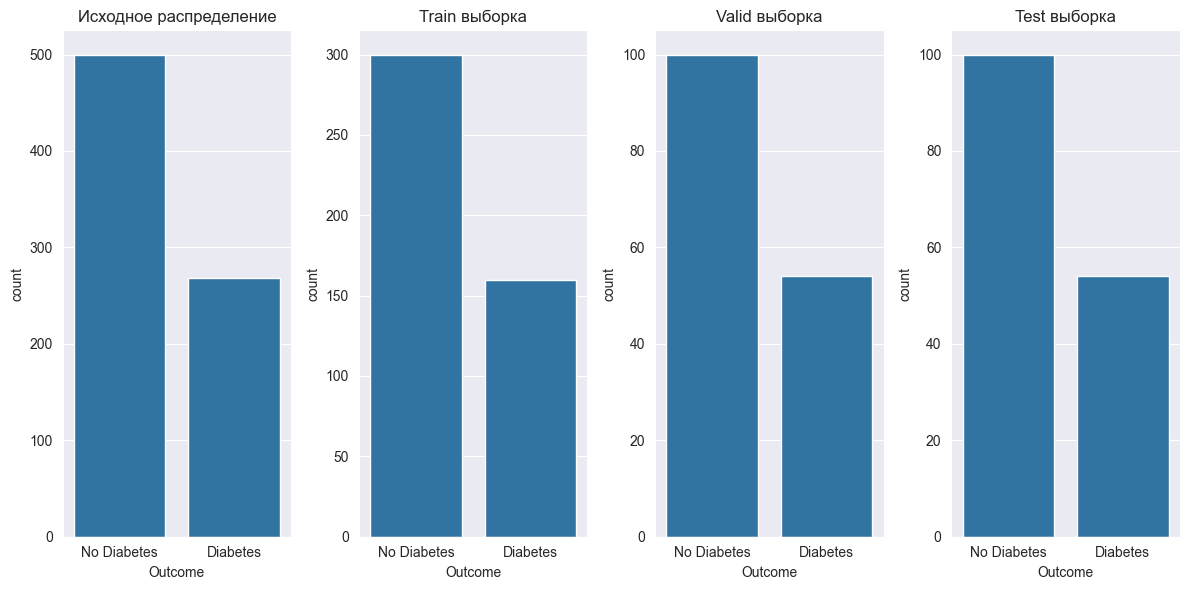

In [10]:
# Визуализация распределения классов в разных выборках
plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
sns.countplot(x=y, order=[0, 1])
plt.title('Исходное распределение')
plt.xticks([0, 1], ['No Diabetes', 'Diabetes'])

plt.subplot(1, 4, 2)
sns.countplot(x=y_train, order=[0, 1])
plt.title('Train выборка')
plt.xticks([0, 1], ['No Diabetes', 'Diabetes'])

plt.subplot(1, 4, 3)
sns.countplot(x=y_valid, order=[0, 1])
plt.title('Valid выборка')
plt.xticks([0, 1], ['No Diabetes', 'Diabetes'])

plt.subplot(1, 4, 4)
sns.countplot(x=y_test, order=[0, 1])
plt.title('Test выборка')
plt.xticks([0, 1], ['No Diabetes', 'Diabetes'])

plt.tight_layout()
plt.show()

In [11]:
# Создание полного пайплаина для будущих моделей
def create_model_pipeline(model):
    """Создание полного пайплаина с препроцессингом и моделью"""
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

print("Функция для создания пайплаинов готова")

Функция для создания пайплаинов готова


In [14]:
# Сохранение разделенных данных для следующих участников
data_split = {
    'X_train': X_train,
    'X_valid': X_valid, 
    'X_test': X_test,
    'y_train': y_train,
    'y_valid': y_valid,
    'y_test': y_test,
    'feature_names': feature_names,
    'preprocessor': preprocessor
}

# Сохранение в файл
import pickle

with open('../data/interim/data_split.pkl', 'wb') as f:
    pickle.dump(data_split, f)

print("Разделенные данные сохранены в файл '../data/interim/data_split.pkl'")

Разделенные данные сохранены в файл '../data/interim/data_split.pkl'


In [15]:
print("=" * 50)
print("ОТЧЕТ УЧАСТНИКА 1: ПОДГОТОВКА ДАННЫХ")
print("=" * 50)

print("\n✅ ВЫПОЛНЕННЫЕ ЗАДАЧИ:")
print("1. Создан репозиторий проекта (ноутбук)")
print("2. Загружен очищенный датасет из ЛР-1")
print("3. Создан sklearn Pipeline с ColumnTransformer")
print("4. Выполнено стратифицированное разбиение 60/20/20")
print("5. Зафиксирован random_state = 42")
print("6. Проверена стратификация для дисбалансных классов")
print("7. Данные сохранены для следующих участников")

print("\n📊 СТАТИСТИКА ДАННЫХ:")
print(f"Общий размер датасета: {df.shape}")
print(f"Количество признаков: {len(feature_names)}")
print(f"Размер train: {X_train.shape} ({len(y_train)/len(df)*100:.1f}%)")
print(f"Размер valid: {X_valid.shape} ({len(y_valid)/len(df)*100:.1f}%)") 
print(f"Размер test: {X_test.shape} ({len(y_test)/len(df)*100:.1f}%)")

print("\n🎯 РАСПРЕДЕЛЕНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ:")
print(f"Класс 0 (нет диабета): {sum(y == 0)} ({sum(y == 0)/len(y)*100:.1f}%)")
print(f"Класс 1 (диабет): {sum(y == 1)} ({sum(y == 1)/len(y)*100:.1f}%)")

print("\n🔧 НАСТРОЙКИ ПРЕПРОЦЕССИНГА:")
print("Все признаки числовые")
print("SimpleImputer: strategy='median'")
print("StandardScaler: стандартизация признаков")
print("Стратификация: включена")

print("\n📁 СОХРАНЕННЫЕ ФАЙЛЫ:")
print("1. diabetes_clean.csv - исходные данные")
print("2. data_split.pkl - разделенные данные для участников 2-5")

ОТЧЕТ УЧАСТНИКА 1: ПОДГОТОВКА ДАННЫХ

✅ ВЫПОЛНЕННЫЕ ЗАДАЧИ:
1. Создан репозиторий проекта (ноутбук)
2. Загружен очищенный датасет из ЛР-1
3. Создан sklearn Pipeline с ColumnTransformer
4. Выполнено стратифицированное разбиение 60/20/20
5. Зафиксирован random_state = 42
6. Проверена стратификация для дисбалансных классов
7. Данные сохранены для следующих участников

📊 СТАТИСТИКА ДАННЫХ:
Общий размер датасета: (768, 9)
Количество признаков: 8
Размер train: (460, 8) (59.9%)
Размер valid: (154, 8) (20.1%)
Размер test: (154, 8) (20.1%)

🎯 РАСПРЕДЕЛЕНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ:
Класс 0 (нет диабета): 500 (65.1%)
Класс 1 (диабет): 268 (34.9%)

🔧 НАСТРОЙКИ ПРЕПРОЦЕССИНГА:
Все признаки числовые
SimpleImputer: strategy='median'
StandardScaler: стандартизация признаков
Стратификация: включена

📁 СОХРАНЕННЫЕ ФАЙЛЫ:
1. diabetes_clean.csv - исходные данные
2. data_split.pkl - разделенные данные для участников 2-5
